In [1]:
import pandas as pd
import numpy as np
import time
from matplotlib import pyplot as plt
import datetime as dt
from zigzag_dag26 import zigzag
import talib
from tqdm import tqdm
import colorama as col

In [2]:
%%time
##### Chargement de la base
base = pd.read_csv('Base_Clean/EURUSDm15.csv')

##### On fixe la date en index sous forme de Timestamp
base.set_index(pd.to_datetime(base.Date),drop=True,inplace=True)

###### On drop les colonnes inutiles
base = base.drop(['Date','Total'],axis=1)

##### On enlève les jours correspondant au samedi et au dimanche
base['WE'] = np.where(((base.index.weekday == 5) | (base.index.weekday == 6)),None,base.index.weekday)
base = base.dropna()
base = base.drop(['WE'],axis=1)


CPU times: user 619 ms, sys: 86.8 ms, total: 706 ms
Wall time: 706 ms


In [3]:
base.index[0],base.index[-1]

(Timestamp('2010-11-23 00:00:00'), Timestamp('2020-11-23 23:45:00'))

In [4]:
%%time
_year_bottom = pd.to_datetime('2020-09-23 16:00:00')
_year_top = pd.to_datetime('2020-11-23 16:00:00') #2020-11-23 16:00:00

df = base[(base.index>=_year_bottom)&(base.index<=_year_top)]

df_input = df.copy()

df_bt = df.copy()

df.head()

CPU times: user 4.16 ms, sys: 1.83 ms, total: 5.99 ms
Wall time: 6.11 ms


,OpenBid,HighBid,LowBid,CloseBid,OpenAsk,HighAsk,LowAsk,CloseAsk,Open,High,Low,Close
Date,,,,,,,,,,,,
2020-09-23 16:00:00,1.16829,1.16832,1.16744,1.16766,1.16842,1.16843,1.16755,1.16780,1.168355,1.168375,1.167495,1.167730
2020-09-23 16:15:00,1.16766,1.16781,1.16639,1.16698,1.16780,1.16792,1.16651,1.16713,1.167730,1.167865,1.166450,1.167055
2020-09-23 16:30:00,1.16698,1.16720,1.16633,1.16692,1.16713,1.16733,1.16646,1.16704,1.167055,1.167265,1.166395,1.166980
2020-09-23 16:45:00,1.16692,1.16741,1.16635,1.16738,1.16704,1.16755,1.16648,1.16750,1.166980,1.167480,1.166415,1.167440
2020-09-23 17:00:00,1.16738,1.16845,1.16710,1.16798,1.16750,1.16858,1.16723,1.16810,1.167440,1.168515,1.167165,1.168040


In [5]:
_deviation = 0.001
_backstep = 3
_depth = 20
df.shape

(4105, 12)

100%|██████████| 4105/4105 [00:01<00:00, 2548.29it/s]
Il y a  82 signaux VALLEY,  81 signaux PEAK, et  3942  signaux sans rien
CPU times: user 1.7 s, sys: 38.3 ms, total: 1.73 s
Wall time: 1.69 s


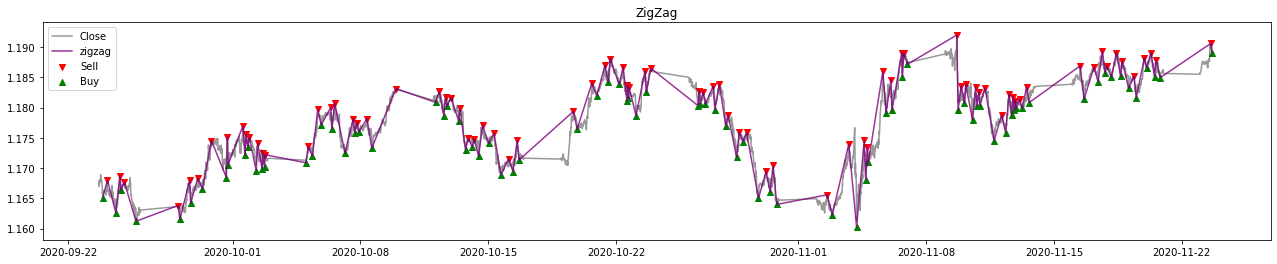

In [6]:
%%time
PEAK,VALLEY = zigzag(df,_deviation, _backstep, _depth)
df['BackHi_pic'] = PEAK
df['BackLo_val'] = VALLEY
#df['BackHi'] = np.where(df.High == df.High.rolling(_backstep).max(),df.High,0)
#df['BackLo'] = np.where(df.Low == df.Low.rolling(_backstep).min(),df.Low,0)

In [7]:
_fibo = 0.618
_err = 0.01

In [8]:
%%time
LASTP1 = []
LASTV1 = []
LASTP2 = []
LASTV2 = []
lastv1 = 0
lastp1 = 0
lastv2 = 0
lastp2 = 0


for i in tqdm(range(len(df))):
    if df.BackLo_val[i] == 1:
        lastv2 = lastv1
        lastv1 = df.Close[i]
        LASTV1.append(lastv1)
        LASTP1.append(lastp1)
        LASTV2.append(lastv2)
        LASTP2.append(lastp2)
    elif df.BackHi_pic[i] == 1:
        lastp2 = lastp1
        lastp1 = df.Close[i]
        LASTP1.append(lastp1)
        LASTV1.append(lastv1)
        LASTP2.append(lastp2)
        LASTV2.append(lastv2)
    else:
        LASTP1.append(lastp1)
        LASTV1.append(lastv1)
        LASTP2.append(lastp2)
        LASTV2.append(lastv2)

df['LastP1'] = LASTP1
df['LastV1'] = LASTV1
df['LastP2'] = LASTP2
df['LastV2'] = LASTV2
df['XAp'] =  df['LastV2'] -  df['LastP2']
df['XAv'] = df['LastP2'] -  df['LastV2']
df['ABp'] = df['LastP1'] -  df['LastV2']
df['ABv'] = df['LastV1'] -  df['LastP2']
df['BCp'] = df['LastV1'] -  df['LastP1']
df['BCv'] = df['LastP1'] -  df['LastV1']
df['CDp'] = df['Close'] - df['LastV1']
df['CDv'] = df['Close'] - df['LastP1']

100%|██████████| 4105/4105 [00:00<00:00, 15129.90it/s]CPU times: user 279 ms, sys: 3.72 ms, total: 283 ms
Wall time: 287 ms



In [9]:
#for i in range(190):
 #   print(i,' --- ',df.LastV1[i],' -------------- ' , df.LastV1[i-1],' ----- ','oui' if df.LastV1[i] == df.LastV1[i-1] else 'non')

In [10]:
#df[['BackHi_pic','BackLo_val','High','Low','LastP1','LastP2','LastV1','LastV2']].iloc[85:125,:]

In [15]:
%%time
BUY = [] 
SELL = [] 
INDEXv = []
VALUEv = []
INDEXp = []
VALUEp = []
_pic = 0
_val = 0
_picklock = 0
_locked = 1

for i in tqdm(range(0,len(df))):

    if df.BackLo_val[i] == 1:
        print('\nVAL a 1, Initiation de recherche PIC en',i,'\n')
        print('\nAffichage CDp',df.CDp[i],' CDv',df.CDv[i],'\n')
        _pic = 1
        _val = 0
        _locked = 0
        _picklock += 1
    
    elif df.BackHi_pic[i] == 1:
        print('\nPIC a 1, Initiation de recherche VAL en',i,'\n')
        print('\nAffichage CDp',df.CDp[i],' CDv',df.CDv[i],'\n')
        _val = 1
        _pic = 0
        _locked = 0
        _picklock += 1
    
    if _picklock < 4:
        _locked = 1


    if _val == 1 and _locked == 0 and abs(df.CDv[i]/df.BCv[i]) > _fibo * (1+_err) :
        print('\n[Mode_VALLEY = ON]\nDate  :',df.index[i],'i : ',i,'\nClose : ',df.Close[i],'\nLastP : ',df.LastP1[i],'\nLastV : ',df.LastV1[i],'\nfibo*(1+err : ',_fibo * (1+_err))
        print('Affichage CDp',df.CDp[i],' CDv',df.CDv[i])
        print('\nho : ',abs(df.CDv[i]),'\n ba : ',abs(df.BCv[i]),'\nletou quessé de lunsurlotr: ',abs(df.CDv[i]/df.BCv[i]),'\n_____________________\n\n')
        VALUEv.append(df.Close[i])
        INDEXv.append(df.index[i])
        BUY.append(1)
        SELL.append(0)
        _val = 0
        _locked = 1

    elif _pic == 1 and _locked == 0 and abs(df.CDp[i]/df.BCp[i]) > _fibo * (1+_err): 
        print('\n[Mode_PEAK = ON]\nDate  :',df.index[i],'i : ',i,'\nClose : ',df.Close[i],'\nLastV : ',df.LastV1[i],'\nLastP : ',df.LastP1[i],'\nfibo*(1+err : ',_fibo * (1+_err))
        print('Affichage CDp',df.CDp[i],' CDv',df.CDv[i])
        print('\nho : ',abs(df.CDp[i]),'\n ba : ',abs(df.BCp[i]),'\nletou quessé de lunsurlotr: ',abs(df.CDp[i]/df.BCp[i]),'\n_____________________\n\n')
        VALUEp.append(df.Close[i])
        INDEXp.append(df.index[i])
        BUY.append(0)
        SELL.append(1)
        _pic = 0
        _locked = 1
        
    else:
        BUY.append(0)
        SELL.append(0)
    
df['BuyRet'] = BUY
df['SellRet'] = SELL

 29%|██▉       | 1185/4105 [00:00<00:00, 5918.60it/s]
VAL a 1, Initiation de recherche PIC en 20 


Affichage CDp 0.0  CDv 1.1658 


PIC a 1, Initiation de recherche VAL en 46 


Affichage CDp 0.0015300000000000313  CDv 0.0 


VAL a 1, Initiation de recherche PIC en 90 


Affichage CDp 0.0  CDv -0.00460499999999997 


PIC a 1, Initiation de recherche VAL en 111 


Affichage CDp 0.005239999999999911  CDv 0.0 


VAL a 1, Initiation de recherche PIC en 116 


Affichage CDp 0.0  CDv -0.0009549999999998171 


PIC a 1, Initiation de recherche VAL en 134 


Affichage CDp 0.0005149999999998212  CDv 0.0 


[Mode_VALLEY = ON]
Date  : 2020-09-25 02:00:00 i :  136 
Close :  1.16706 
LastP :  1.167525 
LastV :  1.16701 
fibo*(1+err :  0.62418
Affichage CDp 4.999999999988347e-05  CDv -0.0004649999999999377

ho :  0.0004649999999999377 
 ba :  0.0005149999999998212 
letou quessé de lunsurlotr:  0.9029126213594159 
_____________________



VAL a 1, Initiation de recherche PIC en 196 


Affichage CDp 0

CPU times: user 95.5 ms, sys: 6.88 ms, total: 102 ms
Wall time: 68.3 ms


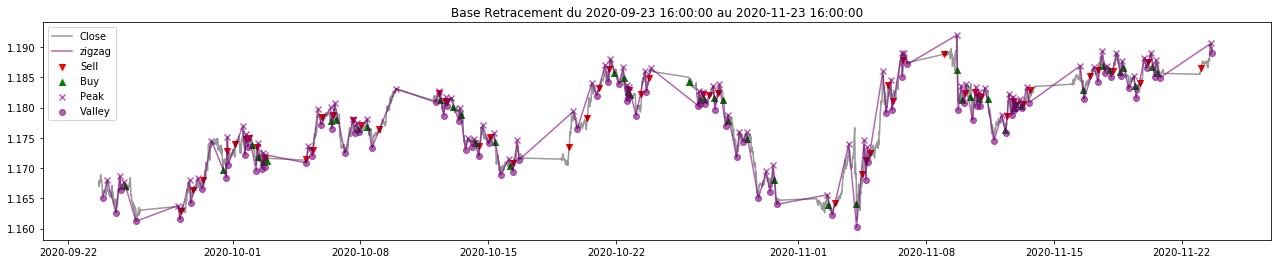

In [16]:
%%time

df_zigzag = pd.DataFrame()
df_zigzag['PeakValley'] = pd.concat([df.BackHi_pic, df.BackLo_val], axis=0, ignore_index=False, sort=True)
df_zigzag['Close'] = pd.concat([df.High, df.Low], axis=0, ignore_index=False, sort=True)
df_zigzag = df_zigzag[df_zigzag.PeakValley==1]
# Sort peak and valley datapoints by date.
df_zigzag = df_zigzag.sort_index()

plt.figure(figsize=(22,4))
plt.title('Base Retracement du '+str(df.index[0])+' au '+str(df.index[-1]))
plt.plot(df.Close,color='black',alpha=0.4,label="Close")
#plt.plot(df.High,color='orange',alpha=0.3,label="High")
#plt.plot(df.Low,color='blue',alpha=0.3,label="Low")
#plt.plot(talib.SMA(df.Close, 200),color='blue',alpha=0.6,label='SMA')


plt.scatter(x=INDEXp,y=VALUEp,color='red',marker='v',label="Sell")
plt.scatter(x=INDEXv,y=VALUEv,color='green',marker='^',label="Buy")

plt.scatter(x=df[df.BackHi_pic==1].index,y=df[df.BackHi_pic==1].High,color='purple',marker='x',label="Peak",alpha=0.6)
plt.scatter(x=df[df.BackLo_val==1].index,y=df[df.BackLo_val==1].Low,color='purple',marker='o',label="Valley",alpha=0.6)
plt.plot(df_zigzag.index.values, df_zigzag['Close'].values,color='purple', label="zigzag",alpha=0.6)
plt.legend()
#plt.savefig('pic.png',dpi=1000)


In [17]:
from vanilla_bt import *
from scipy.ndimage.interpolation import shift

In [20]:
%time
df.Signal = np.where(df.BuyRet == 1,1,np.where(df.SellRet==1,-1,0))
#df.Signal = shift(df.Signal,-1,cval=np.NaN)
bt_tpsl(df,0.01,0.004)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs
fermeture long en l'air
Winner Ratio : 22.22 %
Profit Factor :  2.93 % 
 Période du 2020-09-23 16:00:00 au  2020-11-23 16:00:00 
Nombre de trades : 16
Nombre de posistions non fermées 0
Captital initial : 250000
Taille des positions : 50000
Gain :  3314.500000000009 
Capital Final : 253314.5


()

In [19]:
%%time
df.Signal = np.where(df.BuyRet == 1,1,np.where(df.SellRet==1,-1,0))
bt_tpsl_grid(df)
       

Pour un TP de   0.1  et un SL de   0.1 
fermeture long en l'air
Winner Ratio : 100.0 %
Profit Factor :  inf % 
Nombre de trades : 1
Nombre de posistions non fermées 0
Captital initial : 250000
Taille des positions : 50000
Gain :  1131.9999999999998 
Capital Final : 251132.0

________________________________________________________________________________________

Pour un TP de   0.1  et un SL de   0.09 
fermeture long en l'air
Winner Ratio : 100.0 %
Profit Factor :  inf % 
Nombre de trades : 1
Nombre de posistions non fermées 0
Captital initial : 250000
Taille des positions : 50000
Gain :  1131.9999999999998 
Capital Final : 251132.0

________________________________________________________________________________________

Pour un TP de   0.1  et un SL de   0.08 
fermeture long en l'air
Winner Ratio : 100.0 %
Profit Factor :  inf % 
Nombre de trades : 1
Nombre de posistions non fermées 0
Captital initial : 250000
Taille des positions : 50000
Gain :  1131.9999999999998 
Capital Final : 

()